In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add, ZeroPadding2D, Reshape
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import time
t_start = time.time()

Using TensorFlow backend.


In [2]:
version = 5
basic_name = 'Unet_resnet_v5'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v5.model
Unet_resnet_v5.csv


In [3]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [4]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("/home/nazimgirach/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("/home/nazimgirach/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [5]:
train_df["images"] = [np.array(load_img("/home/nazimgirach/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [6]:
train_df["masks"] = [np.array(load_img("/home/nazimgirach/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [8]:
# Create train/validation split stratified by salt coverage
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = \
train_test_split(train_df.index.values, 
                 np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
                 np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
                 train_df.coverage.values, 
                 train_df.z.values, 
                 test_size=0.2, stratify=train_df.coverage_class, random_state=555)

In [9]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [10]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [11]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [12]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

In [13]:
def myres(x, start_neurons, up = False):
    conv33 = Conv2D(start_neurons, (1,1), strides=(1,1), activation=None, padding='same')(x)
    conv33 = BatchNormalization()(conv33)
    conv33 = Activation('relu')(conv33)
    conv33 = Conv2D(start_neurons, (3,3), strides=(1,1), padding='same')(conv33)
    conv33 = BatchNormalization()(conv33)
    conv33 = Activation('relu')(conv33)
    if up:
        x = Conv2D(start_neurons, (1,1), strides=(1,1), activation=None, padding='same')(x)
        x = BatchNormalization()(x)
        x33 = Add()([conv33, x])
        return x33
    conv33 = Conv2D(start_neurons*4, (1,1), strides=(1,1), activation=None, padding='same')(conv33)
    conv33 = BatchNormalization()(conv33)
    x33 = Add()([conv33, x])
    return x33

In [41]:
# Build Model
def build_resnet(input_layer, start_neurons, DropoutRatio=0.5):
    #101
    #Stage=0 Block=0, stride=(1,1) and Add()
    conv01 = Conv2D(start_neurons, (1,1), strides=(1,1), activation=None, padding='same')(input_layer)
    conv01 = BatchNormalization()(conv01)
    conv01 = Activation('relu')(conv01)
    conv01 = Conv2D(start_neurons, (3,3), strides=(1,1), padding='same')(conv01)
    conv01 = BatchNormalization()(conv01)
    conv01 = Activation('relu')(conv01)
    conv01 = Conv2D(start_neurons*4, (1,1), strides=(1,1), activation=None, padding='same')(conv01)
    conv01a = BatchNormalization()(conv01)
    conv01b = Conv2D(start_neurons*4, (1,1), strides=(1,1), activation=None, padding='same')(input_layer)
    conv01b = BatchNormalization()(conv01b)
    x0 = Add()([conv01a, conv01b])
    
    for i in range(1,3):#3
        x0 = myres(x0, start_neurons)
    #Stage=0 Block=1, stride=(1,1)
    mp = MaxPooling2D((2,2))(x0)
############################################################3
    start_neurons=start_neurons*2
    #50
    #Stage=1 Block=0, stride=(2,2) and Add()
    conv02 = Conv2D(start_neurons, (1,1), strides=(1,1), activation=None, padding='same')(mp)
    conv02 = BatchNormalization()(conv02)
    conv02 = Activation('relu')(conv02)
    conv02 = Conv2D(start_neurons, (3,3), strides=(1,1), padding='same')(conv02)
    conv02 = BatchNormalization()(conv02)
    conv02 = Activation('relu')(conv02)
    conv02 = Conv2D(start_neurons*4, (1,1), strides=(1,1), activation=None, padding='same')(conv02)
    conv02a = BatchNormalization()(conv02)
    conv02b = Conv2D(start_neurons*4, (1,1), strides=(1,1), activation=None, padding='same')(mp)
    conv02b = BatchNormalization()(conv02b)
    x02 = Add()([conv02a, conv02b])
    
    for i in range(1,5):#5
        x02 = myres(x02, start_neurons)
    x1 = x02
##########################################################
    start_neurons=start_neurons*2
    #25
    #Stage=2 Block=0, stride=(2,2) 
    conv03 = Conv2D(start_neurons, (1,1), strides=(2,2), activation=None, padding='same')(x1)
    conv03 = BatchNormalization()(conv03)
    conv03 = Activation('relu')(conv03)
    conv03 = Conv2D(start_neurons, (3,3), strides=(1,1), padding='same')(conv03)
    conv03 = BatchNormalization()(conv03)
    conv03 = Activation('relu')(conv03)
    conv03 = Conv2D(start_neurons*4, (1,1), strides=(1,1), activation=None, padding='same')(conv03)
    conv03a = BatchNormalization()(conv03)
    conv03b = Conv2D(start_neurons*4, (1,1), strides=(2,2), activation=None, padding='valid')(x1)
    conv03b = BatchNormalization()(conv03b)
    x03 = Add()([conv03a, conv03b])
    
    x = x03
    #Stage=2 Block=1, stride=(1,1)
    for i in range(1,8):#8
        x = myres(x, start_neurons)
        
    x2 = x
    ############################################
    start_neurons=start_neurons*2
    #12
    #Stage=3 Block=0, stride=(2,2) and Add()
    mp3= MaxPooling2D((2,2))(x2)
    conv04 = Conv2D(start_neurons, (1,1), strides=(1,1), activation=None, padding='same')(mp3)
    conv04 = BatchNormalization()(conv04)
    conv04 = Activation('relu')(conv04)
    conv04 = Conv2D(start_neurons, (3,3), strides=(1,1), padding='same')(conv04)
    conv04 = BatchNormalization()(conv04)
    conv04 = Activation('relu')(conv04)
    conv04 = Conv2D(start_neurons*4, (1,1), strides=(1,1), activation=None, padding='same')(conv04)
    conv04a = BatchNormalization()(conv04)
    conv04b = Conv2D(start_neurons*4, (1,1), strides=(1,1), activation=None, padding='valid')(mp3)
    conv04b = BatchNormalization()(conv04b)
    x04 = Add()([conv04a, conv04b])
    #Stage=3 Block=1, stride=(1,1)
    x = x04
    for i in range(1,36):#36
        x = myres(x, start_neurons)
    x3 = x
    ###################################################
    start_neurons=start_neurons*2
    #6
    #Stage=4 Block=0, stride=(2,2) and Add()
    conv05 = Conv2D(start_neurons, (1,1), strides=(2,2), activation=None, padding='same')(x3)
    conv05 = BatchNormalization()(conv05)
    conv05 = Activation('relu')(conv05)
    conv05 = Conv2D(start_neurons, (3,3), strides=(1,1), padding='same')(conv05)
    conv05 = BatchNormalization()(conv05)
    conv05 = Activation('relu')(conv05)
    conv05 = Conv2D(start_neurons*4, (1,1), strides=(1,1), activation=None, padding='same')(conv05)
    conv05a = BatchNormalization()(conv05)
    conv05b = Conv2D(start_neurons*4, (1,1), strides=(2,2), activation=None, padding='valid')(x04)
    conv05b = BatchNormalization()(conv05b)
    x05 = Add()([conv05a, conv05b])
    x = x05
    for i in range(1,5):#5
        x = myres(x, start_neurons)
    x4 = x
      
    ####################################################
    # 6 -> 13, 512
    
    deconv4 = Conv2DTranspose(start_neurons, (3,3), strides=(2,2), padding='same')(x4)
    uconv4 = concatenate([deconv4, x3])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    
    uconv4 = Conv2D(start_neurons*2,(3,3), activation=None, padding='same')(uconv4)
    for i in range(1,4):#4
        uconv4 = myres(uconv4, start_neurons*2, True)
    ######################################################
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons, (3,3), strides=(2,2), padding='valid')(uconv4)
    uconv3 = concatenate([deconv3, x2])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons, (3,3), activation=None, padding='same')(uconv3)
    for i in range(1,4):#4
        uconv3 = myres(uconv3, start_neurons, True)
    #######################################################
    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons//2, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, x1])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons//2, (3,3), activation=None, padding='same')(uconv2)
    for i in range(1,4):#4
        uconv2 = myres(uconv2, start_neurons//2, True)
    #########################################################
    conv_50 = Conv2DTranspose(start_neurons//4, (3,3), strides=(2,2), padding='valid')(x1)
    
    conv_25 = Conv2DTranspose(start_neurons//4, (3,3), strides=(2,2), padding='same')(x2)
    conv_25 = Conv2DTranspose(start_neurons//4, (3,3), strides=(2,2), padding='valid')(conv_25)
    
    conv_12 = Conv2DTranspose(start_neurons//4, (3,3), strides=(2,2), padding='valid')(x3)
    conv_12 = Conv2DTranspose(start_neurons//4, (3,3), strides=(2,2), padding='same')(conv_12)
    conv_12 = Conv2DTranspose(start_neurons//4, (3,3), strides=(2,2), padding='valid')(conv_12)

    conv_6 = Conv2DTranspose(start_neurons//4, (3,3), strides=(2,2), padding='same')(x4)
    conv_6 = Conv2DTranspose(start_neurons//4, (3,3), strides=(2,2), padding='valid')(conv_6)
    conv_6 = Conv2DTranspose(start_neurons//4, (3,3), strides=(2,2), padding='same')(conv_6)
    conv_6 = Conv2DTranspose(start_neurons//4, (3,3), strides=(2,2), padding='valid')(conv_6)
    #print(conv_6._keras_shape)
    #########################################################
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons//4, (3,3), strides=(2,2), padding='valid')(uconv2)
    uconv1 = concatenate([deconv1, x0, conv_50, conv_25, conv_12, conv_6])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons//4, (3,3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons//4)
    uconv1 = residual_block(uconv1, start_neurons//4, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding='same', activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [42]:
for i in range(1,8):
    print(i)

1
2
3
4
5
6
7


In [ ]:
G = 8
with tf.device("/cpu:0"):
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_resnet(input_layer, 16,0.5)
    modell = Model(input_layer, output_layer)
    print("done loading model")
# make the model parallel
model = multi_gpu_model(modell, gpus=G)
print("Done parallelizing the model")
# model
c = optimizers.adam(lr = 0.005)
model.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
model.summary()

done loading model


In [ ]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name, monitor='my_iou_metric', mode='max',
                                   save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=8,
                              min_lr=0.00001, verbose=1)
epochs = 1
batch_size = 32
#batch_size = batch_size * G
t_model1_start = time.time()
history = model.fit(x_train, y_train,
                     validation_data = [x_valid, y_valid], 
                     epochs = epochs, 
                     batch_size = batch_size * G,
                     callbacks = [reduce_lr, reduce_lr],
                     verbose = 1)#, steps_per_epoch = len(x_train) // batch_size * G,validation_steps = len(x_valid) // batch_size * G)
t_model1_end = time.time()

print("Run time = "+str((t_model1_end-t_model1_start)/3600)+" hours")
modell.save('my_model.h5')

In [23]:
save_model_name='my_model.h5'
with tf.device("/cpu:0"):
        # initialize the model
    model1 = load_model(save_model_name, custom_objects={'my_iou_metric':my_iou_metric})
        # remove activation layer and use lovasz loss
    input_x = model1.layers[0].input

    output_layer = model1.layers[-1].input
    modell = Model(input_x, output_layer)
    # make the model parallel
model = multi_gpu_model(modell, gpus=G)
c = optimizers.adam(lr=0.001)

model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

model.summary()

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, 101, 101, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_22 (Lambda)              (None, 101, 101, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_23 (Lambda)              (None, 101, 101, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_24 

In [25]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=30, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, 
                              min_lr=0.00005, verbose=1)
epochs = 15
batch_size = 64

t_model2_start = time.time()
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size*G,
                    callbacks=[reduce_lr,early_stopping], 
                    verbose=1)
t_model2_end = time.time()
print("Run time = "+str((t_model2_end-t_model2_start)/3600)+" hours")

Train on 6400 samples, validate on 800 samples
Epoch 1/15
6400/6400 [==============================] - 50s 8ms/step - loss: 0.1241 - my_iou_metric_2: 0.7267 - val_loss: 0.1611 - val_my_iou_metric_2: 0.7231
Epoch 2/15
6400/6400 [==============================] - 49s 8ms/step - loss: 0.0511 - my_iou_metric_2: 0.7414 - val_loss: 0.1625 - val_my_iou_metric_2: 0.7378
Epoch 3/15
6400/6400 [==============================] - 49s 8ms/step - loss: 0.0020 - my_iou_metric_2: 0.7492 - val_loss: 0.1397 - val_my_iou_metric_2: 0.7396
Epoch 4/15
6400/6400 [==============================] - 50s 8ms/step - loss: -0.0270 - my_iou_metric_2: 0.7559 - val_loss: 0.1743 - val_my_iou_metric_2: 0.7342
Epoch 5/15
6400/6400 [==============================] - 49s 8ms/step - loss: -0.0529 - my_iou_metric_2: 0.7623 - val_loss: 0.1982 - val_my_iou_metric_2: 0.7276
Epoch 6/15
6400/6400 [==============================] - 49s 8ms/step - loss: -0.0839 - my_iou_metric_2: 0.7680 - val_loss: 0.2688 - val_my_iou_metric_2: 0.7

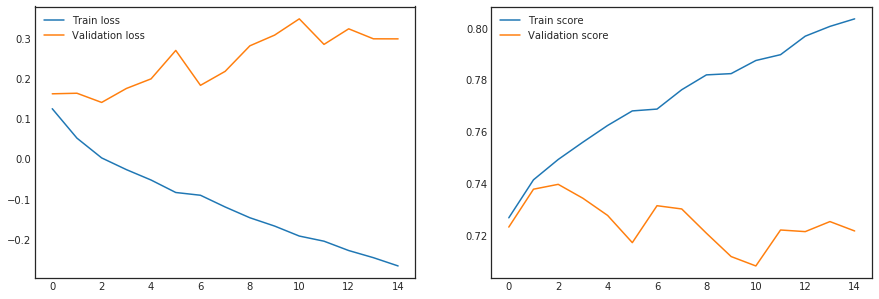

In [26]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [27]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [28]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [29]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [30]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
        
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [31]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.132625 0.132625 0.132625 0.132625 0.132625 0.132625 0.132625 0.132625
 0.132625 0.132625 0.132625 0.132625 0.132625 0.132625 0.132625 0.132625
 0.2995   0.6295   0.694    0.704    0.701125 0.699625 0.6945   0.685875
 0.674875 0.6625   0.64925  0.633375 0.61475  0.58625  0.546125]


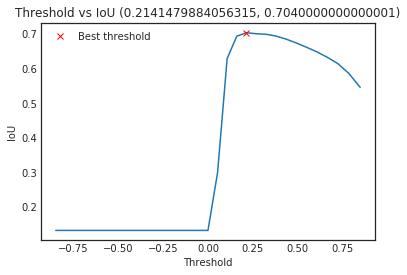

In [32]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, 'xr', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [33]:
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [40]:
x_test = np.array([(np.array(load_img("/home/nazimgirach/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

KeyboardInterrupt: 

In [ ]:
preds_test = predict_result(model,x_test,img_size_target)

In [ ]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [ ]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")